<div class="alert alert-success"> 
        <h1 align="center" style="color:chocolate;">KANs for Loan Approval Prediction
 (Classification)
</h1>  
     
</div>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: white; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>Overview</font></h3>
    
* In this notebook I implement a Kolmogorov-Arnold Network (KAN) for Loan Approval Prediction and compare it against a neural network of a similar architecture.
* this dataset has more data than breast canser prediction and we want to assess KANs on larger datasets.
* The dataset is from Kaggle, available at this https://www.kaggle.com/competitions/playground-series-s4e10
    



# Import Packages


In [9]:
import torch
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

device = 'cpu'

## Loading the Dataset

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer for binary classification

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

# Prepare the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Function to create binary classification tasks
def get_task_dataset(dataset, digit1, digit2):
    # Select indices for the two digits
    indices = [i for i, (x, y) in enumerate(dataset) if y == digit1 or y == digit2]
    task_dataset = Subset(dataset, indices)
    return task_dataset

# Define training function
def train(model, dataloader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        for images, labels in dataloader:
            # Convert labels to binary (e.g., digit1=0, digit2=1)
            labels = (labels == digit2).float().view(-1, 1)  # Set digit2 as label 1
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Define testing function
def test(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            labels = (labels == digit2).float().view(-1, 1)  # Set digit2 as label 1
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()  # Classify as 0 or 1 based on threshold
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Set device, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define tasks and train separately on each task
tasks = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
for task_num, (digit1, digit2) in enumerate(tasks, 1):
    print(f"\nTraining on Task {task_num}: {digit1} vs {digit2}")
    task_dataset = get_task_dataset(mnist_dataset, digit1, digit2)
    dataloader = DataLoader(task_dataset, batch_size=64, shuffle=True)
    
    # Train and test on the current task
    train(model, dataloader, criterion, optimizer)
    test(model, dataloader)




Training on Task 1: 0 vs 1
Epoch [1/3], Loss: 0.0043
Epoch [2/3], Loss: 0.0002
Epoch [3/3], Loss: 0.0001
Test Accuracy: 100.00%

Training on Task 2: 2 vs 3
Epoch [1/3], Loss: 0.1371
Epoch [2/3], Loss: 0.0314
Epoch [3/3], Loss: 0.0660
Test Accuracy: 97.85%

Training on Task 3: 4 vs 5
Epoch [1/3], Loss: 0.0520
Epoch [2/3], Loss: 0.0660
Epoch [3/3], Loss: 0.0061
Test Accuracy: 98.83%

Training on Task 4: 6 vs 7
Epoch [1/3], Loss: 0.0014
Epoch [2/3], Loss: 0.0480
Epoch [3/3], Loss: 0.0006
Test Accuracy: 99.30%

Training on Task 5: 8 vs 9
Epoch [1/3], Loss: 0.1595
Epoch [2/3], Loss: 0.1347
Epoch [3/3], Loss: 0.0781
Test Accuracy: 97.93%


In [63]:
for task_num, (digit1, digit2) in enumerate(tasks, 1):
    print(f"\nTraining on Task {task_num}: {digit1} vs {digit2}")
    task_dataset = get_task_dataset(mnist_dataset, digit1, digit2)
    dataloader = DataLoader(task_dataset, batch_size=64, shuffle=True)
    
    # Train and test on the current task
    test(model, dataloader)


Training on Task 1: 0 vs 1
Test Accuracy: 38.39%

Training on Task 2: 2 vs 3
Test Accuracy: 48.29%

Training on Task 3: 4 vs 5
Test Accuracy: 8.22%

Training on Task 4: 6 vs 7
Test Accuracy: 76.74%

Training on Task 5: 8 vs 9
Test Accuracy: 97.93%


In [64]:
import torch
from torch.utils.data import Subset, random_split
from torchvision import datasets, transforms

# Prepare the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Function to create binary classification tasks and return data as dictionary
def get_task_dataset(dataset, digit1, digit2, train_ratio=0.8):
    # Select indices for the two digits
    indices = [i for i, (x, y) in enumerate(dataset) if y == digit1 or y == digit2]
    
    # Create subset of dataset with just the selected digits
    task_dataset = Subset(dataset, indices)
    
    # Split into training and testing based on train_ratio
    train_size = int(train_ratio * len(task_dataset))
    test_size = len(task_dataset) - train_size
    train_subset, test_subset = random_split(task_dataset, [train_size, test_size])
    
    # Extract inputs and labels for training and testing
    train_x = torch.stack([train_subset[i][0] for i in range(len(train_subset))])
    train_y = torch.tensor([train_subset[i][1] for i in range(len(train_subset))])
    test_x = torch.stack([test_subset[i][0] for i in range(len(test_subset))])
    test_y = torch.tensor([test_subset[i][1] for i in range(len(test_subset))])
    
    # Organize data into the specified dictionary format
    dataset_dict = {
        'train_input': train_x.to(device),
        'train_label': train_y.to(device),
        'test_input': test_x.to(device),
        'test_label': test_y.to(device)
    }
    
    return dataset_dict

# Example usage for Task 1 (0 vs 1)
device = 'cpu'
task_data = get_task_dataset(mnist_dataset, digit1=0, digit2=1)
print(task_data['train_input'][0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

## Creating and Training the KAN

In [92]:
from kan import KAN

model = KAN(width=[784, 2], grid=50, k=3, seed=0, device=device, noise_scale=0.1, sp_trainable=False, sb_trainable=False, base_fun='zero')

checkpoint directory created: ./model
saving model version 0.0


In [93]:
def train_acc():
    return torch.mean((torch.argmax(model(task_dataset['train_input']), dim=1) == task_dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(task_dataset['test_input']), dim=1) == task_dataset['test_label']).float())

In [94]:
N=5

for task_num, (digit1, digit2) in enumerate(tasks, 1):
    print(f"\nTraining on Task {task_num}: {digit1} vs {digit2}")
    task_dataset = get_task_dataset(mnist_dataset, digit1, digit2)
    task_dataset['train_input'] = task_dataset['train_input'].squeeze().reshape((-1,784))
    task_dataset['test_input'] = task_dataset['test_input'].squeeze().reshape((-1,784))
    labels = task_dataset['train_label']
    labels = torch.where(labels == digit1, torch.tensor(0), labels)
    labels = torch.where(labels == digit2, torch.tensor(1), labels)
    task_dataset['train_label'] = labels

    labels = task_dataset['test_label']
    labels = torch.where(labels == digit1, torch.tensor(0), labels)
    labels = torch.where(labels == digit2, torch.tensor(1), labels)
    task_dataset['test_label'] = labels

    dataloader = DataLoader(task_dataset, batch_size=64, shuffle=True)
    results = model.fit(task_dataset, 
                        opt="LBFGS",
                        metrics=(train_acc, test_acc),
                        loss_fn=torch.nn.CrossEntropyLoss(),
                        steps=N, update_grid=False)
    print('Training Accuracy :', results['train_acc'][-1])
    print('Test Accuracy :', results['test_acc'][-1])



Training on Task 1: 0 vs 1


| train_loss: 0.00e+00 | test_loss: 1.12e-01 | reg: 1.31e+02 | : 100%|█| 5/5 [01:34<00:00, 18.81s/it


saving model version 0.1
Training Accuracy : 1.0
Test Accuracy : 0.9976359605789185

Training on Task 2: 2 vs 3


| train_loss: 0.00e+00 | test_loss: 7.55e-01 | reg: 4.91e+02 | : 100%|█| 5/5 [01:51<00:00, 22.25s/it


saving model version 0.2
Training Accuracy : 1.0
Test Accuracy : 0.9657701849937439

Training on Task 3: 4 vs 5


| train_loss: 1.99e-05 | test_loss: 3.49e-01 | reg: 5.55e+02 | : 100%|█| 5/5 [01:56<00:00, 23.30s/it


saving model version 0.3
Training Accuracy : 1.0
Test Accuracy : 0.9866666793823242

Training on Task 4: 6 vs 7


| train_loss: 0.00e+00 | test_loss: 2.68e-01 | reg: 7.84e+02 | : 100%|█| 5/5 [01:40<00:00, 20.16s/it


saving model version 0.4
Training Accuracy : 1.0
Test Accuracy : 0.9949748516082764

Training on Task 5: 8 vs 9


| train_loss: 1.73e-05 | test_loss: 5.46e-01 | reg: 8.30e+02 | : 100%|█| 5/5 [01:59<00:00, 23.87s/it

saving model version 0.5
Training Accuracy : 1.0
Test Accuracy : 0.982367753982544


In [95]:
for task_num, (digit1, digit2) in enumerate(tasks, 1):
    print(f"\nTraining on Task {task_num}: {digit1} vs {digit2}")
    task_dataset = get_task_dataset(mnist_dataset, digit1, digit2)
    task_dataset['train_input'] = task_dataset['train_input'].squeeze().reshape((-1,784))
    task_dataset['test_input'] = task_dataset['test_input'].squeeze().reshape((-1,784))
    labels = task_dataset['train_label']
    labels = torch.where(labels == digit1, torch.tensor(0), labels)
    labels = torch.where(labels == digit2, torch.tensor(1), labels)
    task_dataset['train_label'] = labels

    labels = task_dataset['test_label']
    labels = torch.where(labels == digit1, torch.tensor(0), labels)
    labels = torch.where(labels == digit2, torch.tensor(1), labels)
    task_dataset['test_label'] = labels

    print('Training Accuracy :', train_acc())
    print('Test Accuracy :', test_acc())


Training on Task 1: 0 vs 1
Training Accuracy : tensor(0.4427)
Test Accuracy : tensor(0.3924)

Training on Task 2: 2 vs 3
Training Accuracy : tensor(0.6595)
Test Accuracy : tensor(0.6504)

Training on Task 3: 4 vs 5
Training Accuracy : tensor(0.2168)
Test Accuracy : tensor(0.2347)

Training on Task 4: 6 vs 7
Training Accuracy : tensor(0.9112)
Test Accuracy : tensor(0.9146)

Training on Task 5: 8 vs 9
Training Accuracy : tensor(0.9962)
Test Accuracy : tensor(0.9975)


## Creating and Training the KAN [26, 26, 2]

In [800]:
model = KAN(width=[64, 10], grid=5, k=3, seed=0)

checkpoint directory created: ./model
saving model version 0.0


In [801]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [803]:
%%time

results = model.fit(dataset, 
                    opt="LBFGS",
                    metrics=(train_acc, test_acc),
                    loss_fn=torch.nn.CrossEntropyLoss(),
                    steps=100)

| train_loss: 0.00e+00 | test_loss: 1.67e+00 | reg: 0.00e+00 | : 100%|█| 100/100 [00:31<00:00,  3.23

saving model version 0.1
CPU times: total: 11.5 s
Wall time: 31 s


In [805]:
print('Training Accuracy :', results['train_acc'][-1])
print('Test Accuracy :', results['test_acc'][-1])

Training Accuracy : 1.0
Test Accuracy : 0.9472222328186035


In [795]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total trainable parameters :', params)

Total trainable parameters : 8960


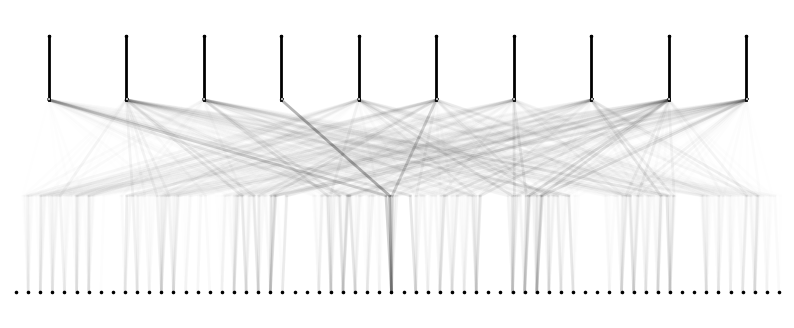

In [797]:
model.plot(scale=1)

In [798]:
model.prune()

saving model version 0.2


MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)

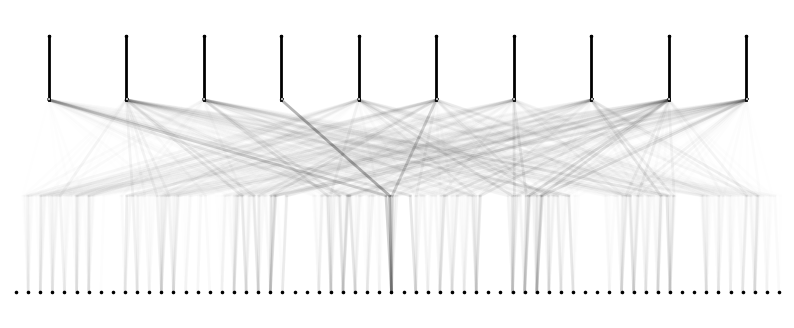

In [799]:
model.plot(scale=1)

# Implementation of a Neural Network for comparison

In [549]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(64, 64)  # 4 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, 5)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    return loss_list

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [550]:
def load_dataset(dataset):
    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(dataset['train_input'], dataset['train_label']), batch_size=1000, shuffle=False)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(dataset['test_input'], dataset['test_label']), batch_size=1000, shuffle=False)

    return train_loader, test_loader


## Train and Evaluate the NN

In [563]:
%%time
N=1000
model = NeuralNetwork().to(device)

CPU times: total: 0 ns
Wall time: 1.03 ms


In [564]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
all_loss=[]

for i in range(5):
    train_loader, test_loader = load_dataset(data_continual_learn(train_data, test_data, i))
    loss_list = train_model(model, train_loader, criterion, optimizer, num_epochs=N)
    all_loss.extend(loss_list)
    test_model(model, train_loader)
    test_model(model, test_loader)

Epoch 1, Loss: 1.507520079612732
Epoch 2, Loss: 1.4637095928192139
Epoch 3, Loss: 1.4208686351776123
Epoch 4, Loss: 1.378673791885376
Epoch 5, Loss: 1.336950421333313
Epoch 6, Loss: 1.2956528663635254
Epoch 7, Loss: 1.254705548286438
Epoch 8, Loss: 1.2138996124267578
Epoch 9, Loss: 1.173111915588379
Epoch 10, Loss: 1.1324132680892944
Epoch 11, Loss: 1.0916846990585327
Epoch 12, Loss: 1.0509356260299683
Epoch 13, Loss: 1.0102969408035278
Epoch 14, Loss: 0.9699493050575256
Epoch 15, Loss: 0.9299038052558899
Epoch 16, Loss: 0.8903675079345703
Epoch 17, Loss: 0.8515154123306274
Epoch 18, Loss: 0.8134735226631165
Epoch 19, Loss: 0.7764548063278198
Epoch 20, Loss: 0.7406299114227295
Epoch 21, Loss: 0.7061376571655273
Epoch 22, Loss: 0.6732175350189209
Epoch 23, Loss: 0.6420173048973083
Epoch 24, Loss: 0.6126375794410706
Epoch 25, Loss: 0.5851629972457886
Epoch 26, Loss: 0.5596614480018616
Epoch 27, Loss: 0.5361722707748413
Epoch 28, Loss: 0.5146927833557129
Epoch 29, Loss: 0.495166540145874


Text(0, 0.5, 'Loss')

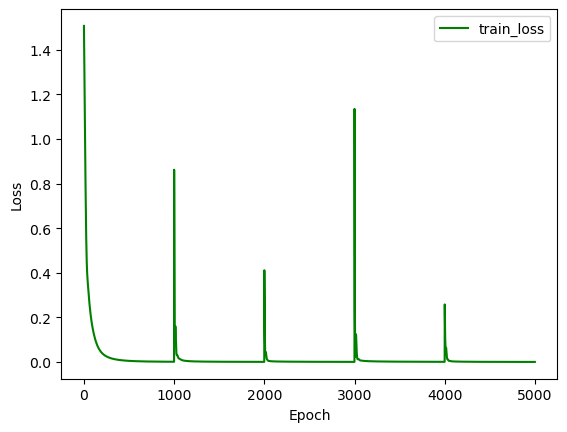

In [565]:
plt.plot(all_loss, 'g', label='train_loss') 
#plt.plot(range(N),results['test_loss'], 'y', label='validation_loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [566]:
test_model(model, test_loader)

Accuracy: 94.47513812154696%


In [567]:
test_model(model, train_loader)

Accuracy: 100.0%


In [429]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

4485

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: green; font-size:100%; text-align:left">

<h3 align="center"><font color='white'>💡 Summary from above :</font></h3>

1. Neural Network architecture is much better than KAN 
